In [1]:
import random
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd
import pickle

seed_number = 2024
random.seed(seed_number)
np.random.seed(seed_number)
tf.random.set_seed(seed_number)




2024-11-17 18:04:03.379370: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-17 18:04:03.402890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-17 18:04:03.402920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-17 18:04:03.403838: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 18:04:03.408184: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def save_data_pickle(file_path, data):
    with open(file_path, 'wb') as file:
        pickle.dump(data, file)

def load_data_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

In [3]:
import requests

def send_telegram_message(message):
    bot_token = '797390018:AAHWSVCdBvXnERxnz4kI4ACvrfu_Rq7xLxc'
    chat_id = '626444855'
    
    response = requests.get(f'https://api.telegram.org/bot{bot_token}/sendMessage?chat_id={chat_id}&text={message}')
    
    if response.status_code == 200:
        print('Mensagem enviada com sucesso!')
    else:
        print(f'Falha ao enviar a mensagem. Código de status: {response.status_code}')



In [4]:
def augment_image_individually(X, Y, max_shift=8, max_rotation=1, brightness_range=0.5, num_augmentations=10, pct_noise=0.02):
    
    num_augmentations = 10
    X_data = []
    Y_data = []
    for original_frames, y in tqdm(zip(X, Y), total=len(X)):
        
        X_data.append(original_frames)
        Y_data.append(y)
               
        for _ in range(num_augmentations):
            augmented_frames = []
            for frame in original_frames:
                dx = np.random.randint(-max_shift, max_shift)
                angulo = np.random.uniform(-max_rotation, max_rotation)
                fator_brilho = np.random.uniform(1 - brightness_range, 1 + brightness_range)
                h_flip = np.random.choice([True, False])
                v_flip = np.random.choice([True, False])
                rotate = np.random.choice([0, 90, 180, 270])
                noise_factor = random.uniform(0, 1)
                pct_noise = noise_factor * pct_noise
                apply_blur = np.random.choice([True, False])
                shear_range = 0
                swap_channels = np.random.choice([True, False])
            
                augmented_frames.append(augment_image(frame, dx, angulo, fator_brilho, h_flip, v_flip, rotate, pct_noise,
                                                    apply_blur=apply_blur, shear_range=shear_range, swap_channels=swap_channels))
            x = np.array(augmented_frames)
            X_data.append(x)
            Y_data.append(y)
            
            
            
    return np.array(X_data), np.array(Y_data)
        
        

In [5]:
import requests

def send_telegram_image(image_path):
    bot_token = '797390018:AAHWSVCdBvXnERxnz4kI4ACvrfu_Rq7xLxc'
    chat_id = '626444855'
    
    # URL da API do Telegram para enviar fotos
    url = f'https://api.telegram.org/bot{bot_token}/sendPhoto'
    
    # Abrir a imagem no modo binário e enviá-la
    with open(image_path, 'rb') as image_file:
        response = requests.post(url, data={'chat_id': chat_id}, files={'photo': image_file})
    
    # Verificar a resposta
    if response.status_code == 200:
        print('Imagem enviada com sucesso!')
    else:
        print(f'Falha ao enviar a imagem. Código de status: {response.status_code}')



In [6]:
def send_telegram_file(file_path, caption=""):
    bot_token = '797390018:AAHWSVCdBvXnERxnz4kI4ACvrfu_Rq7xLxc'
    chat_id = '626444855'
    
    # URL da API do Telegram para enviar arquivos
    url = f'https://api.telegram.org/bot{bot_token}/sendDocument'
    
    # Abrir o arquivo no modo binário e enviá-lo
    with open(file_path, 'rb') as file:
        response = requests.post(url, data={'chat_id': chat_id, 'caption': caption}, files={'document': file})
    
    # Verificar a resposta
    if response.status_code == 200:
        print('Arquivo enviado com sucesso!')
    else:
        print(f'Falha ao enviar o arquivo. Código de status: {response.status_code}, Resposta: {response.text}')

In [7]:
frames_folder_path='frames'
egg_data_sheet_path='dados_ovos.xlsx'
final_frame_shape = (50, 50)
grayscale=True
possible_objective_columns = ['Massa Total Aferido','Clara','Gema','Casca','Gema + Clara']
# objective_columns = ['Massa Total Aferido','Clara','Gema','Casca','Gema + Clara']
objective_columns = ['Massa Total Aferido','Clara','Gema + Clara']
# objective_columns = ['Clara']


additional_feature_list = []

In [8]:
def select_frames_with_spacing(total_frames=36, num_selected_frames=8):
    """
    Seleciona `num_selected_frames` frames igualmente espaçados de um conjunto de `total_frames`.
    O ponto de partida é selecionado aleatoriamente e a contagem é circular se ultrapassar o limite.
    """
    start_index = random.randint(0, total_frames - 1)
    spacing = total_frames // num_selected_frames
    selected_indices = [(start_index + i * spacing) % total_frames for i in range(num_selected_frames)]
    return selected_indices

In [9]:
def load_frames(egg_index, colors=['green', 'red', 'blue', 'white'], videos=[1, 2], base_path='frames',
                resize_ratio=1.0, grayscale=False, max_frames_by_color=6, final_frame_shape=(100, 100), write_index=False):
    frames = []

    # Verifica se `videos` é um valor único ou uma lista
    if not isinstance(videos, list):
        videos = [videos]

    # Cria os caminhos dos vídeos
    videos_paths = []
    for i in videos:
        videos_folder_path = os.listdir(os.path.join(base_path, f'egg_{egg_index}'))
        videos_paths.append(videos_folder_path[i - 1])

    for video_path in videos_paths:
        for color in colors:
            path = os.path.join(base_path, f'egg_{egg_index}', video_path, color)
            frame_files = sorted(os.listdir(path))  # Ordena para manter a sequência

            if len(frame_files) < max_frames_by_color:
                raise ValueError(f"Número insuficiente de frames na cor {color} para o ovo {egg_index}.")

            # Seleciona índices de frames com espaçamento
            selected_indices = select_frames_with_spacing(len(frame_files), max_frames_by_color)
            window_frames = []

            for idx in selected_indices:
                frame_path = os.path.join(path, frame_files[idx])
                frame = cv2.imread(frame_path, cv2.IMREAD_COLOR)
                if resize_ratio != 1.0:
                    frame = cv2.resize(frame, None, fx=resize_ratio, fy=resize_ratio, interpolation=cv2.INTER_AREA)

                if grayscale:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

                # Adiciona bordas pretas para tornar a imagem quadrada, se necessário
                width, height = 100, 100
                top = bottom = (height - frame.shape[0]) // 2
                left = right = (width - frame.shape[1]) // 2
                if (height - frame.shape[0]) % 2 != 0:
                    bottom += 1
                if (width - frame.shape[1]) % 2 != 0:
                    right += 1
                frame = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

                if final_frame_shape != frame.shape[:2]:
                    frame = cv2.resize(frame, final_frame_shape, interpolation=cv2.INTER_AREA)
                    
                if write_index:
                    # write idx in the middle of the frame
                    idx_text = f"{color}_{idx}"
                    cv2.putText(frame, idx_text, (0, frame.shape[0] // 2), cv2.FONT_HERSHEY_COMPLEX, 0.3, (255, 255, 255), 1)

                frames.append(frame)

            # frames.append(window_frames)

    return np.array(frames)

In [10]:
df_result = pd.read_excel(egg_data_sheet_path)
# Remove rows that column "100% - Massa Total Calc/Aferida" is > 0.01
df_result = df_result[df_result["100% - Massa Total Calc/Aferida"] <= 0.02]
# Remove rows that column "1 - Casca Aferida/Calculada" is > 0.05
# df_result = df_result[df_result['1 – Casca Aferida/Calculada'] <= 0.05]
# Separate columns Índice and Gema
df_result = df_result[["Índice"]+objective_columns]
# Delete row with Nan
df_result = df_result.dropna()
# Remove indice 476 because it has no frames
df_result = df_result[df_result['Índice']!= 476]
print(f"Len of dataset: {len(df_result)}")
df_result.head()


Len of dataset: 149


,Índice,Massa Total Aferido,Clara,Gema + Clara
0,6,51.61,30.58,44.68
1,8,54.43,29.40,47.57
4,14,53.84,31.94,46.85
5,16,55.46,35.13,48.02
6,18,47.53,28.44,41.23


In [11]:
print(df_result['Índice'].unique())

[  6   8  14  16  18  20  22  27  29  35  39  41  47  52  54  58  64  68
  70  72  74  86  90  92  98 101 103 107 109 111 115 117 119 121 125 127
 129 131 133 135 137 139 141 143 145 147 149 155 157 159 163 165 167 204
 212 214 221 227 229 231 233 235 237 239 241 243 251 253 255 261 263 265
 267 269 271 273 277 285 287 289 293 295 299 301 303 307 309 311 313 315
 317 319 321 323 325 404 406 408 410 412 414 418 420 422 424 434 436 438
 440 442 446 448 450 454 456 458 460 462 468 470 478 480 488 496 498 502
 504 506 510 512 514 518 618 620 622 624 626 628 630 632 634 638 640 654
 656 660 662 664 672]


In [12]:
egg_indexes = []
for egg_index_path in os.listdir(frames_folder_path):
    egg_index = int(egg_index_path.split('_')[1])
    if egg_index in df_result['Índice'].values:
        egg_indexes.append(int(egg_index))
#remove index 476 because it has no frames
# egg_indexes.remove(476)
# egg_indexes.remove(127)
random.shuffle(egg_indexes)

In [13]:
invalid_amount = len(os.listdir(frames_folder_path)) - len(egg_indexes)
print(f"Valid eggs: {len(egg_indexes)}. Invalid eggs: {invalid_amount}. Total eggs: {len(os.listdir(frames_folder_path))}")
print(f"Valid eggs: {len(egg_indexes) / len(os.listdir(frames_folder_path)) * 100:.2f}%. Invalid eggs: {invalid_amount / len(os.listdir(frames_folder_path)) * 100:.2f}%")

Valid eggs: 149. Invalid eggs: 80. Total eggs: 229
Valid eggs: 65.07%. Invalid eggs: 34.93%


In [14]:
# Split the eggs into train, validation and test sets
train_split = 0.6
validation_split = 0.2
test_split = 0.2

train_indexes = egg_indexes[:int(len(egg_indexes) * train_split)]
validation_indexes = egg_indexes[int(len(egg_indexes) * train_split):int(len(egg_indexes) * (train_split + validation_split))]
test_indexes = egg_indexes[int(len(egg_indexes) * (train_split + validation_split)):]
test_indexes.sort()

In [15]:
#index amount by set
print(f"Train: {len(train_indexes)}. Validation: {len(validation_indexes)}. Test: {len(test_indexes)}")


Train: 89. Validation: 30. Test: 30


In [16]:
colors = ['blue','green','red', 'white']
# colors = ['white']
max_frames_by_color = 8
num_originals_per_egg = 30

In [17]:
frames_example = load_frames(egg_index=410, colors=colors, videos=[1,2], base_path=frames_folder_path, 
                             resize_ratio=0.1, grayscale=grayscale, max_frames_by_color=max_frames_by_color, 
                             final_frame_shape=final_frame_shape, write_index=True)

In [18]:
frames_example.shape

(64, 50, 50)

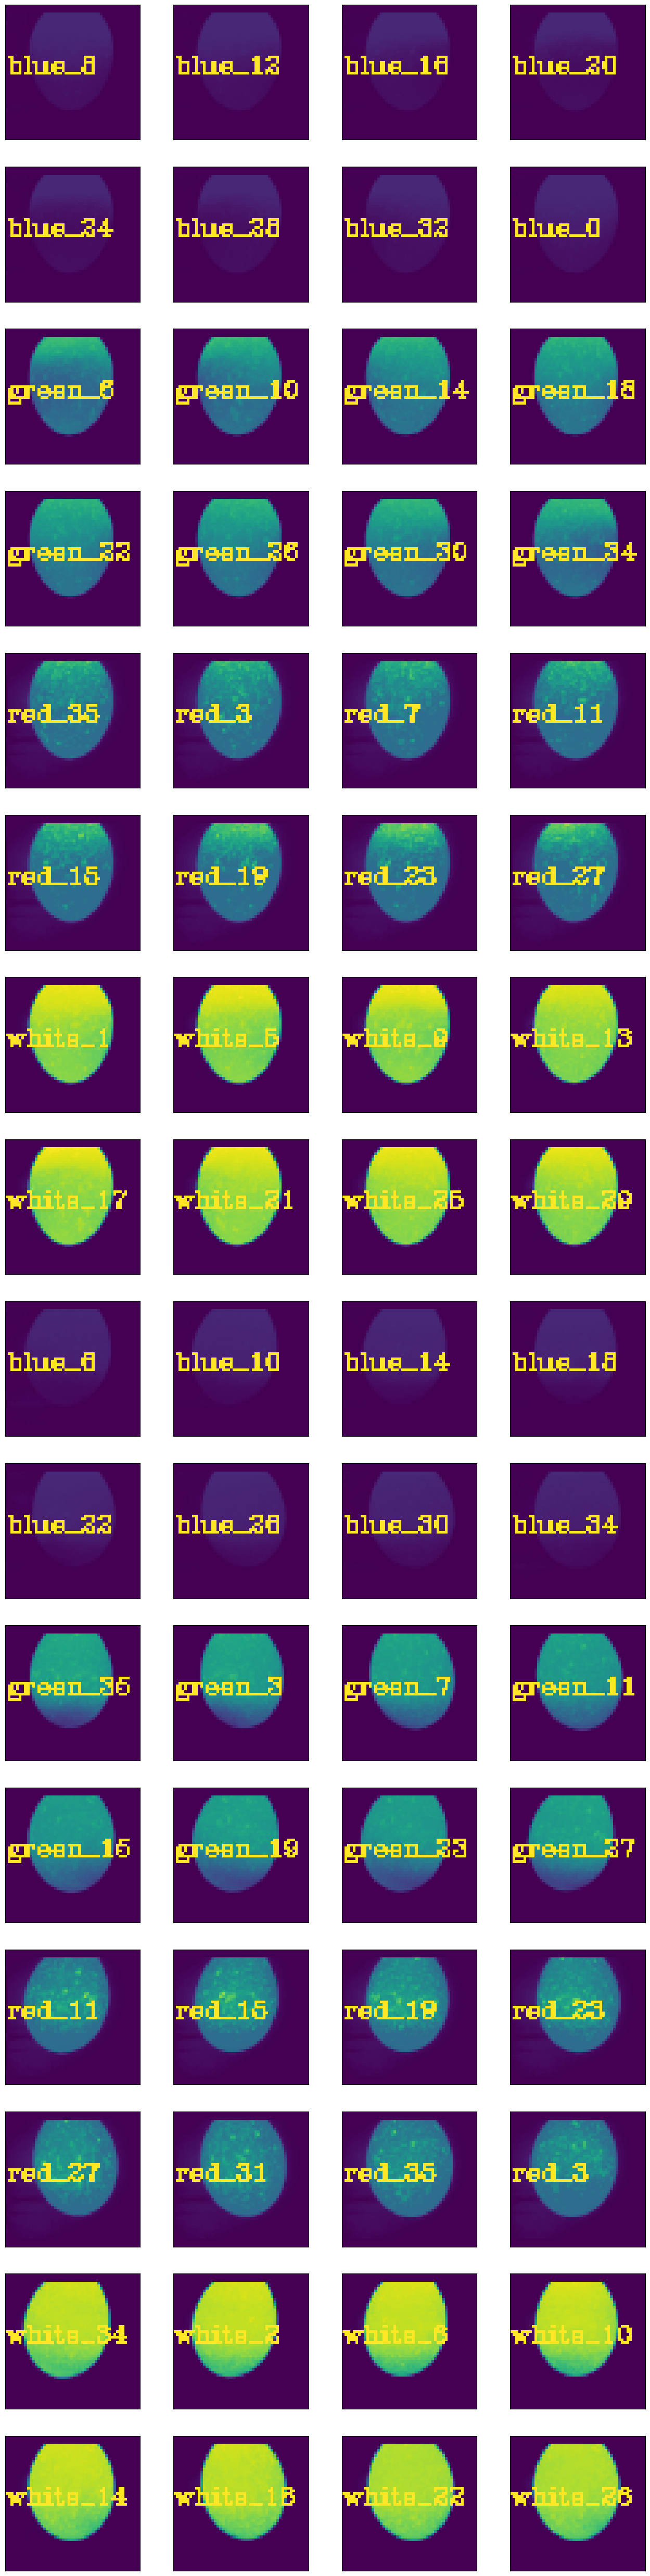

In [19]:
import matplotlib.pyplot as plt

# Número de frames no `frames_example`
num_frames = len(frames_example)

# Configurações para exibir 4 imagens por linha
cols = 4
rows = (num_frames + cols - 1) // cols  # Calcula o número necessário de linhas

# Configura o tamanho da figura para garantir que as imagens não sejam encolhidas
plt.figure(figsize=(cols * 4, rows * 4))  # Ajuste o multiplicador (4) para alterar o tamanho final

# Plota cada frame
for i in range(num_frames):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(frames_example[i])
    plt.xticks([])
    plt.yticks([])

plt.show()


In [20]:
grayscale

True

In [21]:
if grayscale:
  num_frames, altura_frame, largura_frame = frames_example.shape
  channels = 1
else:
  num_frames, altura_frame, largura_frame, channels = frames_example.shape
print(frames_example.shape)

(64, 50, 50)


In [22]:
image = cv2.imread('Screenshot from 2024-11-15 03-17-08.png')

num_pixels = int(image.shape[0] * image.shape[1] * 0.02)
y_coords = np.random.randint(0, image.shape[0], num_pixels)
x_coords = np.random.randint(0, image.shape[1], num_pixels)
if len(image.shape) == 3:
    noise = np.random.randint(0, 256, (num_pixels, image.shape[2]), dtype=np.uint)
else:
    noise = np.random.randint(0, 256, num_pixels, dtype=np.uint8)
image[y_coords, x_coords] = noise
cv2.imwrite('a.png', image)

True

In [23]:
def augment_image(image, dx, angulo, fator_brilho, h_flip, v_flip, rotate, pct_noise,
                  apply_blur=False, shear_range=False, swap_channels=False):
    altura, largura = image.shape[:2]
    
    # Adição de ruído
    if pct_noise:
        num_pixels = int(image.shape[0] * image.shape[1] * pct_noise)
        y_coords = np.random.randint(0, image.shape[0], num_pixels)
        x_coords = np.random.randint(0, image.shape[1], num_pixels)
        if len(image.shape) == 3:
            noise = np.random.randint(0, 256, (num_pixels, image.shape[2]), dtype=np.uint)
        else:
            noise = np.random.randint(0, 256, num_pixels, dtype=np.uint8)
        image[y_coords, x_coords] = noise
    
    # Translação
    M_shift = np.float32([[1, 0, dx], [0, 1, 0]])
    image = cv2.warpAffine(image, M_shift, (largura, altura))
    
    # Flip horizontal e vertical
    if h_flip:
        image = cv2.flip(image, 1)
    if v_flip:
        image = cv2.flip(image, 0)
    
    # Rotação
    if rotate == 90:
        image = cv2.transpose(image)
        image = cv2.flip(image, 1)
    elif rotate == 180:
        image = cv2.flip(image, -1)
    elif rotate == 270:
        image = cv2.transpose(image)
        image = cv2.flip(image, 0)
    
    # Ajuste de brilho
    image = cv2.convertScaleAbs(image, alpha=fator_brilho)
    
    if shear_range:
        altura, largura = image.shape[:2]
        shear_value = np.random.uniform(-shear_range, shear_range)
        M = np.array([[1, shear_value, 0], [0, 1, 0]], dtype=np.float32)
        image = cv2.warpAffine(image, M, (largura, altura))

    # Aplicar desfoque
    if apply_blur:
        cv2.GaussianBlur(image, (3,3), 0)
        

    # Inversão de canais de cor
    if swap_channels:
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image


In [24]:
def load_all_data(indexes, colors, videos, base_path, resize_ratio, df_result,
                  num_originals_per_egg=num_originals_per_egg, grayscale=False, augment=False, max_shift=5, max_rotation=360,
                  brightness_range=0.5, max_amount=None, num_augmentations=8, shuffle=True, max_frames_by_color=max_frames_by_color, 
                  pct_noise=0.02, shuffle_frames=True, additional_feature_list=None, final_frame_shape=(100,100)):
    X_data = []
    Y_data = []
    X_additional_feature = []

    for egg_index in tqdm(indexes[:max_amount]):
        try:
            for _ in range(num_originals_per_egg):
                original_frames = load_frames(egg_index, colors, videos, base_path, resize_ratio,
                                              grayscale=grayscale, max_frames_by_color=max_frames_by_color, final_frame_shape=final_frame_shape)
                obj_value = df_result[df_result['Índice'] == egg_index][objective_columns].iloc[0]
                if additional_feature_list:
                    additional_feature = df_result[df_result['Índice'] == egg_index][additional_feature_list].iloc[0]
                else:
                    additional_feature = 0

                # Adicionar os arranjos originais
                X_data.append(original_frames)
                Y_data.append(obj_value)
                X_additional_feature.append(additional_feature)

                if augment:
                    for _ in range(num_augmentations):
                        augmented_frames = []
                        for frame in original_frames:
                            dx = np.random.randint(-max_shift, max_shift)
                            angulo = np.random.uniform(-max_rotation, max_rotation)
                            fator_brilho = np.random.uniform(1 - brightness_range, 1 + brightness_range)
                            h_flip = np.random.choice([True, False])
                            v_flip = np.random.choice([True, False])
                            rotate = np.random.choice([0, 90, 180, 270])
                            noise_factor = random.uniform(0, 1)
                            pct_noise = noise_factor * pct_noise
                            apply_blur = np.random.choice([True, False])
                            shear_range = 0
                            swap_channels = np.random.choice([True, False])

                            augmented_frames.append(augment_image(frame, dx, angulo, fator_brilho, h_flip, v_flip, rotate, pct_noise,
                                                                  apply_blur=apply_blur, shear_range=shear_range, swap_channels=swap_channels))
                        x = np.array(augmented_frames)
                        
                        # shuffle np.array para fazer o shuffle
                        if shuffle_frames:
                            random.shuffle(x)
                        X_data.append(x)
                        Y_data.append(obj_value)
                        X_additional_feature.append(additional_feature)

        except Exception as e:
            print(f"Erro ao carregar ovo {egg_index}: {e}")

    if shuffle:
        data = list(zip(X_data, Y_data, X_additional_feature))
        random.shuffle(data)
        X_data, Y_data, X_additional_feature = zip(*data)

    return np.array(X_data), np.array(Y_data), np.array(X_additional_feature)

In [25]:
# # Carregando dados para treino, validação e teste
max_amount=None
num_augmentations=10
max_frames_by_color = 8
num_originals_per_egg = 30

In [ ]:

# X_train, Y_train, X_train_additional = load_all_data(train_indexes, colors, [1, 2], frames_folder_path, 0.1, df_result, 
#                                                      num_originals_per_egg=num_originals_per_egg, grayscale=grayscale, augment=True, 
#                                                      max_shift=8, max_rotation=1, brightness_range=0.5, 
#                                                      max_amount=max_amount, num_augmentations=0, shuffle=True,
#                                                      max_frames_by_color=max_frames_by_color, pct_noise=0.02,shuffle_frames=True, final_frame_shape=final_frame_shape)

# X_val, Y_val, X_val_additional = load_all_data(validation_indexes, colors, [1, 2], frames_folder_path, 0.1, df_result, 
#                                                num_originals_per_egg=num_originals_per_egg, grayscale=grayscale, augment=True, 
#                                                max_shift=8, max_rotation=1, brightness_range=0.5, 
#                                                max_amount=max_amount, num_augmentations=0, shuffle=True,
#                                                max_frames_by_color=max_frames_by_color, pct_noise=0.02,shuffle_frames=True, final_frame_shape=final_frame_shape)

# X_test, Y_test, X_test_additional = load_all_data(test_indexes, colors, [1, 2], frames_folder_path, 0.1, df_result, 
#                                                   num_originals_per_egg=num_originals_per_egg, grayscale=grayscale, augment=False, 
#                                                   shuffle=False, max_frames_by_color=max_frames_by_color,
#                                                   max_amount=max_amount, final_frame_shape=final_frame_shape)


In [27]:
# #save arrays
# np.save(f'X_train_sem_aumentacao{"_colorido" if not grayscale else ""}.npy', X_train)
# np.save(f'X_train_additional_sem_aumentacao{"_colorido" if not grayscale else ""}.npy', X_train_additional)
# np.save(f'Y_train_sem_aumentacao{"_colorido" if not grayscale else ""}.npy', Y_train)

# np.save(f'X_val_sem_aumentacao{"_colorido" if not grayscale else ""}.npy', X_val)
# np.save(f'X_val_additional_sem_aumentacao{"_colorido" if not grayscale else ""}.npy', X_val_additional)
# np.save(f'Y_val_sem_aumentacao{"_colorido" if not grayscale else ""}.npy', Y_val)

# np.save(f'X_test_sem_aumentacao{"_colorido" if not grayscale else ""}.npy', X_test)
# np.save(f'X_test_additional_sem_aumentacao{"_colorido" if not grayscale else ""}.npy', X_test_additional)
# np.save(f'Y_test_sem_aumentacao{"_colorido" if not grayscale else ""}.npy', Y_test)


In [28]:

# X_train = np.load(f'X_train_sem_aumentacao{"_colorido" if not grayscale else ""}.npy')
# X_train_additional = np.load(f'X_train_additional_sem_aumentacao{"_colorido" if not grayscale else ""}.npy')
# Y_train = np.load(f'Y_train_sem_aumentacao{"_colorido" if not grayscale else ""}.npy')

# X_val = np.load(f'X_val_sem_aumentacao{"_colorido" if not grayscale else ""}.npy')
# X_val_additional = np.load(f'X_val_additional_sem_aumentacao{"_colorido" if not grayscale else ""}.npy')
# Y_val = np.load(f'Y_val_sem_aumentacao{"_colorido" if not grayscale else ""}.npy')

# X_test = np.load(f'X_test_sem_aumentacao{"_colorido" if not grayscale else ""}.npy')
# X_test_additional = np.load(f'X_test_additional_sem_aumentacao{"_colorido" if not grayscale else ""}.npy')
# Y_test = np.load(f'Y_test_sem_aumentacao{"_colorido" if not grayscale else ""}.npy')

                





In [29]:
# #print len train_indexes, len validation_indexes, len test_indexes
# print(f"X_train_indexes: {len(train_indexes)}, X_val_indexes: {len(validation_indexes)}, X_test_indexes: {len(test_indexes)}")
# print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

In [30]:
# # Join X-train e X_val embaralha e depois X_train e 80% e X_val e 20%


# new_X = np.concatenate((X_train, X_val), axis=0)
# new_Y = np.concatenate((Y_train, Y_val), axis=0)


# from sklearn.model_selection import train_test_split

# # Divida 80% para treino e 20% para validação
# X_train, X_val, Y_train, Y_val = train_test_split(new_X, new_Y, test_size=0.2, random_state=2024)

# del(new_X, new_Y)




In [31]:
# #print len train_indexes, len validation_indexes, len test_indexes
# print(f"X_train_indexes: {len(train_indexes)}, X_val_indexes: {len(validation_indexes)}, X_test_indexes: {len(test_indexes)}")
# print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

In [32]:
# X_train, Y_train = augment_image_individually(X_train, Y_train, max_shift=8, max_rotation=1, brightness_range=0.5,
#                                             num_augmentations=10, pct_noise=0.02)
# X_val, Y_val = augment_image_individually(X_val, Y_val, max_shift=8, max_rotation=1, brightness_range=0.5,
#                                             num_augmentations=10, pct_noise=0.02)


In [33]:
# #save arrays
# np.save(f'X_train_com_aumentacao_misturado{"_colorido" if not grayscale else ""}.npy', X_train)
# np.save(f'Y_train_com_aumentacao_misturado{"_colorido" if not grayscale else ""}.npy', Y_train)

# np.save(f'X_val_com_aumentacao_misturado{"_colorido" if not grayscale else ""}.npy', X_val)
# np.save(f'Y_val_com_aumentacao_misturado{"_colorido" if not grayscale else ""}.npy', Y_val)


In [34]:
grayscale

True

In [41]:
# X_train = np.load(f'X_train_com_aumentacao_misturado{"_colorido" if not grayscale else ""}.npy')
# Y_train = np.load(f'Y_train_com_aumentacao_misturado{"_colorido" if not grayscale else ""}.npy')

# X_val = np.load(f'X_val_com_aumentacao_misturado{"_colorido" if not grayscale else ""}.npy')
# Y_val = np.load(f'Y_val_com_aumentacao_misturado{"_colorido" if not grayscale else ""}.npy')

# X_test = np.load(f'X_test_sem_aumentacao{"_colorido" if not grayscale else ""}.npy')
# Y_test = np.load(f'Y_test_sem_aumentacao{"_colorido" if not grayscale else ""}.npy')


X_train = np.load(f'X_train_com_aumentacao_misturado_colorido.npy')
Y_train = np.load(f'Y_train_com_aumentacao_misturado_colorido.npy')

X_val = np.load(f'X_val_com_aumentacao_misturado_colorido.npy')
Y_val = np.load(f'Y_val_com_aumentacao_misturado_colorido.npy')

X_test = np.load(f'X_test_sem_aumentacao_colorido.npy')
Y_test = np.load(f'Y_test_sem_aumentacao_colorido.npy')



In [42]:
import numpy as np
import cv2

def convert_to_grayscale(X):
    n_samples, seq_len, height, width, channels = X.shape
    if channels != 3:
        raise ValueError("As imagens devem estar no formato RGB (última dimensão deve ser 3)")
    X_aux = []
    for x in tqdm(X):
        x_aux = []
        for frame in x:
            x_aux.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
        X_aux.append(np.array(x_aux))
            
    return np.array(X_aux)

# Converter os conjuntos para grayscale
X_train = convert_to_grayscale(X_train)
X_val = convert_to_grayscale(X_val)
X_test = convert_to_grayscale(X_test)


# Verificar os formatos dos dados convertidos
print(f"Formato X_train: {X_train.shape}")
print(f"Formato X_val: {X_val.shape}")
print(f"Formato X_test: {X_test.shape}")



100%|██████████| 900/900 [00:00<00:00, 6121.20it/s]


NameError: name 'X_train_gray' is not defined

In [ ]:
# # Salvar os conjuntos convertidos, caso deseje
# np.save('X_train.npy', X_train)
# np.save('X_val.npy', X_val)
# np.save('X_test.npy', X_test)

In [43]:
#print len train_indexes, len validation_indexes, len test_indexes
print(f"X_train_indexes: {len(train_indexes)}, X_val_indexes: {len(validation_indexes)}, X_test_indexes: {len(test_indexes)}")
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

X_train_indexes: 89, X_val_indexes: 30, X_test_indexes: 30
X_train shape: (31416, 64, 50, 50), X_val shape: (7854, 64, 50, 50), X_test shape: (900, 64, 50, 50)


In [37]:

# for i in range(len(X_train)):
#     #shuffle frames
#     X_train[i] = random.sample(list(X_train[i]), len(X_train[i]))
# for i in range(len(X_val)):
#     #shuffle frames
#     X_val[i] = random.sample(list(X_val[i]), len(X_val[i]))
  
# for i in range(len(X_test)):
#     #shuffle frames
#     X_test[i] = random.sample(list(X_test[i]), len(X_test[i]))

In [44]:
objective_columns

['Massa Total Aferido', 'Clara', 'Gema + Clara']

In [45]:
# # Criar novos arrays com as formas corretas para armazenar os valores "embaralhados"
# used_indexes = []

# for item in objective_columns:
#     used_indexes.append(possible_objective_columns.index(item))

# print("used_indexes", used_indexes)

# Y_train_aux = np.empty((len(Y_train), len(used_indexes)))  # Novo array com forma adequada
# Y_val_aux = np.empty((len(Y_val), len(used_indexes)))
# Y_test_aux = np.empty((len(Y_test), len(used_indexes)))
# # Preencher os novos arrays com os valores "embaralhados"
# for i in range(len(Y_train)):
#     Y_train_aux[i] = Y_train[i][used_indexes]
# for i in range(len(Y_val)):
#     Y_val_aux[i] = Y_val[i][used_indexes]
# for i in range(len(Y_test)):
#     Y_test_aux[i] = Y_test[i][used_indexes]
  
# Y_train, Y_val, Y_test = Y_train_aux, Y_val_aux, Y_test_aux


In [46]:
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (31416, 64, 50, 50), Y_train shape: (31416, 3)
X_val shape: (7854, 64, 50, 50), Y_val shape: (7854, 3)
X_test shape: (900, 64, 50, 50), Y_test shape: (900, 3)


In [47]:
len(test_indexes)

30

In [48]:
# Salvar cada imagem do x_train[X]
random_index = random.randint(0, len(X_train))
# random_index = 229
if os.path.exists('frames_train'):
    os.system('rm -rf frames_train')
os.makedirs('frames_train', exist_ok=True)
print("random_index", random_index)
for i, image in enumerate(X_train[random_index]):
    cv2.imwrite(f'frames_train/{random_index}_{i}.jpg', image)

random_index 22882


In [49]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, LSTM, TimeDistributed, Dropout, RepeatVector, Reshape, BatchNormalization
from keras.models import Model 
from keras.regularizers import l2

def create_model(num_frames, altura_frame, largura_frame, channels):
    input_shape = (num_frames, altura_frame, largura_frame, channels)

    input_layer = Input(shape=input_shape)
    x = TimeDistributed(Conv2D(16, (3, 3), activation='relu'))(input_layer)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    # x = TimeDistributed(Dropout(0.2))(x)


    # Terceira camada convolucional
    x = TimeDistributed(Conv2D(8, (3, 3), activation='relu'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    # x = TimeDistributed(Dropout(0.2))(x)
    
    # x = TimeDistributed(Flatten())(x)

    x = Flatten()(x)

    # Fully Connected Layers
    # x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    # x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)  # Adicionar Dropout nas camadas densas
    x = Dense(16, activation='relu')(x)
    # x = Dense(8, activation='relu')(x)
    x = Dense(len(objective_columns))(x)
    
    # Modifique esta linha para incluir ambos os inputs
    model = Model(inputs=input_layer, outputs=x)

    return model


In [50]:
# Calculando a média dos valores reais
real_mean = Y_val.mean()
mae_mean = abs(Y_val - real_mean).mean()
print(f"Média real: {real_mean:.4f}. MAE da média: {mae_mean:.4f}")

Média real: 44.4330. MAE da média: 9.1330


In [51]:
# from keras.utils import plot_model

# plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=False,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=200,
#     show_layer_activations=True,
#     show_trainable=False,
# )

In [52]:
objective_columns

['Massa Total Aferido', 'Clara', 'Gema + Clara']

In [53]:
#load keras model
from keras.models import load_model
# model = load_model('model_best_all.keras')
# model = load_model('model_best_total_mass_mae_sam_grayscale.keras')
model = create_model(num_frames, altura_frame, largura_frame, channels)


2024-11-17 18:11:48.725550: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-17 18:11:48.843795: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-17 18:11:48.843941: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [54]:
from keras.callbacks import Callback
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from datetime import datetime

class TestEvaluationCallback(Callback):
    def __init__(self, model, X_test, Y_test, objective_columns, interval=10):
        super(TestEvaluationCallback, self).__init__()
        self.model = model
        self.X_test = X_test
        self.Y_test = Y_test
        self.objective_columns = objective_columns
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        # Checa se é uma época múltipla de "interval" (exemplo: 10)
        if epoch % self.interval == 0 and epoch != 0:
            print(f"\nEvaluating on test set at epoch {epoch}")
            send_telegram_message(f"Test metrics at epoch {epoch}")
            # Fazer previsões
            Y_pred = self.model.predict(self.X_test)

            # Inicializar um dicionário para armazenar DataFrames separados para cada coluna de saída
            result_dfs = {}
            metrics = {}

            # Iterar sobre cada coluna de saída e preencher os resultados em DataFrames separados
            mape_str = ''
            for idx, col_name in enumerate(self.objective_columns):
                result = {
                    "real": self.Y_test[:, idx],
                    "predict": Y_pred[:, idx],
                    "difference": abs(Y_pred[:, idx] - self.Y_test[:, idx])
                }
                # Criar DataFrame para a saída específica
                result_dfs[col_name] = pd.DataFrame(result)

                # Calcular as métricas
                mae = mean_absolute_error(result_dfs[col_name]['real'], result_dfs[col_name]['predict'])
                mape = mean_absolute_percentage_error(result_dfs[col_name]['real'], result_dfs[col_name]['predict'])
                mse = mean_squared_error(result_dfs[col_name]['real'], result_dfs[col_name]['predict'])
                r2 = r2_score(result_dfs[col_name]['real'], result_dfs[col_name]['predict'])

                # Armazenar as métricas no dicionário
                metrics[col_name] = {
                    'MAE': mae,
                    'MAPE': mape,
                    'MSE': mse,
                    'R2': r2
                }
                
                send_telegram_message(f"{col_name} MAE: {mae:.4f}, MAPE: {mape:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")


            # Se desejar, pode enviar as métricas ou salvar em um arquivo
            # send_telegram_message(f"Métricas: {metrics_df.to_string()}")
            
            #se r2 da clara ser maior que 0,7 salva o modelo sendo modelo_{datetime}_{epoch}.keras
            
            if metrics['Clara']['R2'] > 0.7:
                model_path = f'model_{epoch}.keras'
                model.save(model_path)
                send_telegram_message(f"Modelo salvo com R2 maior que 0.7: model_{datetime}_{epoch}.keras")
                send_telegram_file(model_path)
            
# Criar a instância do callback com os parâmetros adequados
test_evaluation_callback = TestEvaluationCallback(
    model=model,
    X_test=X_test,
    Y_test=Y_test,
    objective_columns=objective_columns,
    interval=25
)

In [55]:
class SaveHistoryToExcelCallback(Callback):
    def __init__(self, filepath, save_freq=100):
        super(SaveHistoryToExcelCallback, self).__init__()
        self.filepath = filepath
        self.save_freq = save_freq
        self.history_data = {}

    def on_epoch_end(self, epoch, logs=None):
        # Adiciona os logs da época atual ao histórico
        for key, value in logs.items():
            if key not in self.history_data:
                self.history_data[key] = []
            self.history_data[key].append(value)

        # Salva o histórico a cada `save_freq` épocas
        if (epoch + 1) % self.save_freq == 0:
            df = pd.DataFrame(self.history_data)
            df.to_excel(self.filepath, index=False)

In [56]:
from datetime import datetime
send_telegram_message(f"Treinamento iniciado em {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Mensagem enviada com sucesso!


In [57]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam


# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

history = None

batch_size = 50
epochs = 10000
patience = 100

# def weighted_mape_loss(y_true, y_pred):
#     weights = tf.constant([0.25, 0.5, 0.25])  # Pesos normalizados
#     mape = tf.abs((y_true - y_pred) / tf.clip_by_value(tf.abs(y_true), 1e-9, tf.reduce_max(y_true)))
#     weighted_mape = mape * weights
#     return tf.reduce_mean(weighted_mape)
# model.compile(optimizer=Adam(learning_rate=0.001), 
#               loss=weighted_mape_loss, 
#               metrics=['mape'])

# model.compile(optimizer='adam', loss='mape', metrics=['mae','mape'])
model.compile(optimizer=Adam(lr=0.0001), loss='mape', metrics=['mape'])


# Caminho do arquivo onde você deseja salvar o modelo
model_checkpoint_path = f'model_best_total_mass_mae_sam_{"grayscale" if grayscale else "color"}.keras'

# Criar o callback ModelCheckpoint
model_checkpoint_callback = ModelCheckpoint(
    model_checkpoint_path,
    monitor='val_loss', 
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Criar o callback EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=patience,  # Número de épocas sem melhoria após o qual o treinamento será interrompido
    verbose=1,
    mode='min',
    restore_best_weights=True  # Restaura os pesos do melhor modelo encontrado
)

history_path = f'model_history_{datetime.now().strftime("%d-%m-%Y_%H%M%S")}.xlsx'
save_history_callback = SaveHistoryToExcelCallback(filepath=history_path, save_freq=10)


# Treinamento do modelo com os callbacks
history = model.fit(
    X_train,
    Y_train, 
    steps_per_epoch=int(len(X_train)/4/batch_size),
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(X_val, Y_val),
    validation_steps=int(len(X_val)/4/batch_size),
    callbacks=[model_checkpoint_callback, early_stopping_callback, TensorBoard(log_dir='./logs', histogram_freq=1), test_evaluation_callback, save_history_callback],
    
)

# tensorboard --logdir logs --bind_all


Epoch 1/10000


2024-11-17 18:11:59.688402: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-11-17 18:11:59.688430: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-11-17 18:11:59.688511: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-11-17 18:11:59.688521: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-11-17 18:11:59.688541: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-11-17 18:11:59.688560: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] 

  6/157 [>.............................] - ETA: 27s - loss: 100.1907 - mape: 100.1907WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0710s vs `on_train_batch_end` time: 0.0966s). Check your callbacks.


157/157 [==============================] - ETA: 0s - loss: 94.1898 - mape: 94.1898
Epoch 1: val_loss improved from inf to 69.14515, saving model to model_best_total_mass_mae_sam_grayscale.keras
157/157 [==============================] - 40s 211ms/step - loss: 94.1898 - mape: 94.1898 - val_loss: 69.1451 - val_mape: 69.1451
Epoch 2/10000
157/157 [==============================] - ETA: 0s - loss: 55.0576 - mape: 55.0576
Epoch 2: val_loss improved from 69.14515 to 28.98888, saving model to model_best_total_mass_mae_sam_grayscale.keras
157/157 [==============================] - 31s 198ms/step - loss: 55.0576 - mape: 55.0576 - val_loss: 28.9889 - val_mape: 28.9889
Epoch 3/10000
157/157 [==============================] - ETA: 0s - loss: 15.9247 - mape: 15.9247
Epoch 3: val_loss improved from 28.98888 to 9.97590, saving model to model_best_total_mass_mae_sam_grayscale.keras
157/157 [==============================] - 31s 198ms/step - loss: 15.9247 - mape: 15.9247 - val_loss: 9.9759 - val_mape: 

In [75]:
int(len(X_train)/4/batch_size),int(len(X_val)/4/batch_size)

(157, 39)

In [58]:
import datetime
send_telegram_message(datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

Mensagem enviada com sucesso!


In [59]:
# #load the best model
# from keras import models
# # model = models.load_model(model_checkpoint_path)
# model = models.load_model('model_teste.keras')

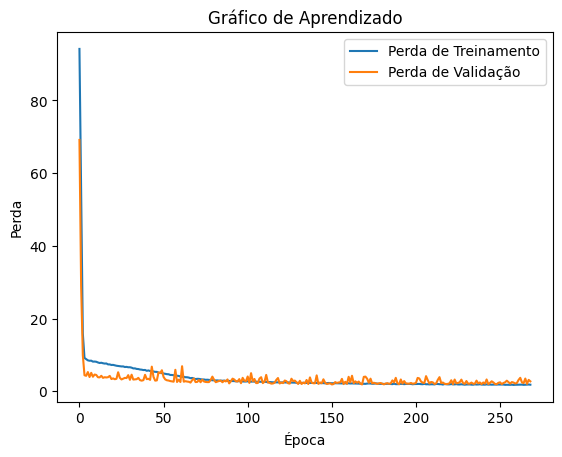

In [60]:
import matplotlib.pyplot as plt
if history:
    # Plotar a perda de treinamento e validação
    plt.plot(history.history['loss'], label='Perda de Treinamento')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title('Gráfico de Aprendizado')
    plt.ylabel('Perda')
    plt.xlabel('Época')
    plt.legend()
    #save the figure as a PNG file
    plt.savefig('training_loss.png')
    plt.show()

In [61]:
if history:
    send_telegram_image('training_loss.png')
    history_df = pd.DataFrame(history.history)

    # Save the history DataFrame to a CSV file
    history_df.to_csv(f'training_history_mass_sam_{"grayscale" if grayscale else "color"}.csv', index=False)
    
    send_telegram_file(history_path)


Imagem enviada com sucesso!
Arquivo enviado com sucesso!


In [62]:
performance = model.evaluate(X_test, Y_test, verbose=0)
print(f"The model's performance is {performance[1]:.4f} MAE on the test set")
#print the mape
# print(f"MAE: {performance[1]:.4f}, MAPE: {performance[1]:.4f}")
# send_telegram_message(f"MAE: {performance[1]:.4f}, MAPE: {performance[1]:.4f}")



The model's performance is 2.0764 MAE on the test set


In [63]:
# Fazer as previsões
Y_pred = model.predict(X_test)

# Inicializar um dicionário para armazenar DataFrames separados para cada coluna de saída
result_dfs = {}

# Iterar sobre cada coluna de saída e preencher os resultados em DataFrames separados
for idx, col_name in enumerate(objective_columns):
    result = {
        "real": Y_test[:, idx],
        "predict": Y_pred[:, idx],
        "difference": abs(Y_pred[:, idx] - Y_test[:, idx])
    }
    # Criar DataFrame para a saída específica
    result_dfs[col_name] = pd.DataFrame(result)

# # Adicionar "Casca Calculada", "Gema Calculada" e "Clara Calculada" aos DataFrames
# result_dfs['Casca Calculada'] = result_dfs['Massa Total Aferido'] - result_dfs['Gema + Clara']
# result_dfs['Gema Calculada'] = result_dfs['Gema + Clara'] - result_dfs['Clara']
# result_dfs['Clara Calculada'] = result_dfs['Gema + Clara'] - result_dfs['Gema']

# result_dfs['Casca Calculada 2'] = result_dfs['Massa Total Aferido'] - result_dfs['Gema'] - result_dfs['Clara']
# result_dfs['Gema Calculada 2'] = result_dfs['Massa Total Aferido'] - result_dfs['Casca'] - result_dfs['Clara']
# result_dfs['Clara Calculada 2'] = result_dfs['Gema + Clara'] - result_dfs['Casca'] - result_dfs['Gema']



29/29 [==============================] - 1s 30ms/step


In [64]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import pandas as pd

# Criar um dicionário para armazenar as métricas para cada coluna
metrics = {}

# Calcular as métricas para cada objetivo (variável de saída)
for col_name, df in result_dfs.items():
    mae = mean_absolute_error(df['real'], df['predict'])
    mape = mean_absolute_percentage_error(df['real'], df['predict'])
    mse = mean_squared_error(df['real'], df['predict'])
    r2 = r2_score(df['real'], df['predict'])
    
    # Armazenar as métricas no dicionário
    metrics[col_name] = {
        'MAE': mae,
        'MAPE': mape,
        'MSE': mse,
        'R2': r2
    }

# Printar as métricas para cada objetivo
# for col_name, metric_values in metrics.items():
#     print(f"Métricas para {col_name}: mae = {metric_values['MAE']:.2f}, mape = {100 * metric_values['MAPE']:.2f}%, mse = {metric_values['MSE']:.2f}, r2 = {metric_values['R2']:.2f}")
#     # send_telegram_message(f"Métricas para {col_name}: mae = {metric_values['MAE']:.2f}, mape = {100 * metric_values['MAPE']:.2f}%, mse = {metric_values['MSE']:.2f}, r2 = {metric_values['R2']:.2f}")

# Converter o dicionário de métricas em um DataFrame e ordenar alfabeticamente
metrics_df = pd.DataFrame(metrics).T.sort_index()  # Transpor e ordenar pelo índice

# Exibir o DataFrame com as métricas
print("\nResumo das métricas (em ordem alfabética):")
print(metrics_df)

# for col_name, metric_values in metrics.items():
    # print(f"Métricas para {col_name}: mae = {metric_values['MAE']:.2f}, mape = {100 * metric_values['MAPE']:.2f}%, mse = {metric_values['MSE']:.2f}, r2 = {metric_values['R2']:.2f}")
    # send_telegram_message(f"Métricas para {col_name}: mae = {metric_values['MAE']:.2f}, mape = {100 * metric_values['MAPE']:.2f}%, mse = {metric_values['MSE']:.2f}, r2 = {metric_values['R2']:.2f}")




Resumo das métricas (em ordem alfabética):
                          MAE      MAPE       MSE        R2
Clara                1.268024  0.039847  2.898831  0.743754
Gema + Clara         0.551090  0.011476  0.832599  0.967141
Massa Total Aferido  0.601783  0.010968  0.884190  0.969288


In [65]:
# Printar as métricas para cada objetivo

for col_name, metric_values in metrics.items():
    # print(f"Métricas para {col_name}: mae = {metric_values['MAE']:.2f}, mape = {100 * metric_values['MAPE']:.2f}%, mse = {metric_values['MSE']:.2f}, r2 = {metric_values['R2']:.2f}")
    send_telegram_message(f"Métricas para {col_name}: mae = {metric_values['MAE']:.2f}, mape = {100 * metric_values['MAPE']:.2f}%, mse = {metric_values['MSE']:.2f}, r2 = {metric_values['R2']:.2f}")

Mensagem enviada com sucesso!
Mensagem enviada com sucesso!
Mensagem enviada com sucesso!


In [66]:
import matplotlib.pyplot as plt
import os

# Criar uma pasta para salvar os gráficos, se não existir
output_dir = "graficos_preditos_vs_reais"
os.makedirs(output_dir, exist_ok=True)

# Criar gráficos para cada variável de saída
for col_name, df in result_dfs.items():
    plt.figure(figsize=(8, 6))
    
    # Gráfico de valor predito vs. valor real
    plt.scatter(df['real'], df['predict'], alpha=0.7, label='Predito vs Real')
    
    # Adicionar a linha ideal (diagonal) - a linha perfeita Y = X
    min_value = min(df['real'].min(), df['predict'].min())
    max_value = max(df['real'].max(), df['predict'].max())
    plt.plot([min_value, max_value], [min_value, max_value], 'r--', label='Ideal (Y=X)')

    # Adicionar título e rótulos
    plt.title(f"Comparação entre Valores Preditos e Reais para {col_name}")
    plt.xlabel("Valores Reais (Massa)")
    plt.ylabel("Valores Preditos (Massa)")
    plt.legend()
    plt.grid(True)

    # Salvar o gráfico em arquivo
    file_path = os.path.join(output_dir, f"grafico_predito_vs_real_{col_name}.png")
    plt.savefig(file_path)
    send_telegram_image(file_path)
    plt.close()

    print(f"Gráfico salvo em: {file_path}")

# Confirmar que os gráficos foram gerados
print("Todos os gráficos foram salvos com sucesso.")


Imagem enviada com sucesso!
Gráfico salvo em: graficos_preditos_vs_reais/grafico_predito_vs_real_Massa Total Aferido.png
Imagem enviada com sucesso!
Gráfico salvo em: graficos_preditos_vs_reais/grafico_predito_vs_real_Clara.png
Imagem enviada com sucesso!
Gráfico salvo em: graficos_preditos_vs_reais/grafico_predito_vs_real_Gema + Clara.png
Todos os gráficos foram salvos com sucesso.


In [67]:
# Exemplo de uso
from datetime import datetime
send_telegram_file(model_checkpoint_path, f"Modelo Treinado {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


Arquivo enviado com sucesso!


In [68]:
model_checkpoint_path

'model_best_total_mass_mae_sam_grayscale.keras'

In [69]:
msg = str(model.summary())
send_telegram_message(msg)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 50, 50, 1)]   0         
                                                                 
 time_distributed (TimeDist  (None, 64, 48, 48, 16)    160       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 64, 24, 24, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 64, 22, 22, 8)     1160      
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 64, 11, 11, 8)     0         
 stributed)                                                  

In [70]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 50, 50, 1)]   0         
                                                                 
 time_distributed (TimeDist  (None, 64, 48, 48, 16)    160       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 64, 24, 24, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 64, 22, 22, 8)     1160      
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 64, 11, 11, 8)     0         
 stributed)                                                  

In [71]:
send_telegram_message(f""" 
                      max_frames_by_color = {max_frames_by_color}
                      num_originals_per_egg = {num_originals_per_egg}
                      num_augmentations = {num_augmentations}
                      final_frame_shape = {final_frame_shape}
                      X_train.shape = {X_train.shape}
                      X_test.shape = {X_test.shape}
                      X_val.shape = {X_val.shape}
                      objective_columns = {objective_columns}
                      len train_indexes = {len(train_indexes)}
                      len test_indexes = {len(test_indexes)}
                      len validation_indexes = {len(validation_indexes)}
                      """)
                      

Mensagem enviada com sucesso!


In [80]:
pd.DataFrame(Y_test, columns=objective_columns).to_csv('Y_test_gray.csv')

In [81]:
pd.DataFrame(Y_pred, columns=objective_columns).to_csv('Y_pred_gray.csv')